In [1]:
import os
from os.path import join
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    InputLayer, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout)
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f"TensorFlow: {tf.__version__}")

Fontconfig warning: ignoring UTF-8: not a valid region tag


TensorFlow: 2.2.0


# Prepare Pedestrian Dataset

In [2]:
!which python

/Users/Pavlo/miniconda3/envs/donkey/bin/python


In [3]:
ls ../data

arrow_sign/           pedestrian_new/       stop_sign/
arrow_sign_v2/        pedestrians_at_start/ stop_sign_v2/
car_dataset/          steering/             zebra_dataset/
hard_track/           steering_night/


In [4]:
ls ../data/pedestrian_new

with/    without/


In [5]:
ls ../data/pedestrians_at_start

with/    without/


In [6]:
ls ../data/zebra_dataset/

with/    without/


In [7]:
ls ../data/pedestrian_new/with | wc -l

   10192


In [8]:
ls ../data/pedestrian_new/without | wc -l

   10108


In [9]:
ls ../data/zebra_dataset/with | wc -l

    2693


In [10]:
ls ../data/zebra_dataset/without | wc -l

    2647


In [11]:
ls ../data/pedestrians_at_start/with | wc -l

    1335


In [12]:
ls ../data/pedestrians_at_start/without | wc -l

     535


In [13]:
data_path = "../data"
data_path_zebra = join(data_path, "zebra_dataset")
data_path_pedestrian = join(data_path, "pedestrian_new")
data_path_start = join(data_path, "pedestrians_at_start")

data_path_steering = join(data_path, "steering")
data_path_dark = join(data_path, "steering_night")
data_path_hard = join(data_path, "hard_track")

In [14]:
label_with = 1
label_without = 0

In [15]:
ls {data_path_steering}

tub_3_22-10-25/ tub_5_22-10-27/ tub_7_22-11-01/
tub_4_22-10-25/ tub_6_22-11-01/ tub_8_22-11-03/


In [58]:
steering_images = []
for thing in os.listdir(data_path_steering):
    if thing.startswith("tub") and not thing.startswith("tub_3"):
        tub_path = join(data_path_steering, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))

In [59]:
len(steering_images)

62463

In [42]:
steering_images[:10]

['../data/steering/tub_6_22-11-01/images/8580_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/9006_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/11761_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/8704_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/9282_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/7739_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/10063_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/4979_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/11792_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/10214_cam_image_array_.jpg']

In [60]:
random.seed(2022)
images = random.sample(steering_images, k=2000)

In [61]:
images[:10]

['../data/steering/tub_8_22-11-03/images/18667_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/404_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/16856_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/19572_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3388_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/15374_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/663_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/17728_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/9922_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/14072_cam_image_array_.jpg']

In [62]:
labels = [label_without]*len(images)

In [63]:
len(images)

2000

In [64]:
ls {data_path_hard}

tub_1_23-01-21/


In [65]:
N_HARD_IMAGES = 2000
hard_images_path = join(data_path_hard, "tub_1_23-01-21", "images")
hard_track_images = [join(hard_images_path, img) for img in os.listdir(hard_images_path)]
random.seed(2022)
images += random.sample(hard_track_images, k=N_HARD_IMAGES)
labels += [label_without]*N_HARD_IMAGES

In [66]:
len(images)

4000

In [67]:
ls {data_path_dark}

tub_1_22-12-04/ tub_2_22-12-04/ tub_3_22-12-04/ tub_4_22-12-04/


In [68]:
N_DARK_IMAGES = 2000
steering_images = []
for thing in os.listdir(data_path_dark):
    if thing.startswith("tub"):
        tub_path = join(data_path_dark, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))

random.seed(2022)
images += random.sample(steering_images, k=N_DARK_IMAGES)
labels += [label_without]*N_DARK_IMAGES

In [69]:
len(images)

6000

In [70]:
for dataset_path in [data_path_zebra, data_path_pedestrian, data_path_start]:
    for img in os.listdir(join(dataset_path, "with")):
        images.append(join(dataset_path, "with", img))
        labels.append(1)
    for img in os.listdir(join(dataset_path, "without")):
        images.append(join(dataset_path, "without", img))
        labels.append(0)

In [71]:
len(images)

33510

In [72]:
corrupt_images = []
for i, img in enumerate(images):
    if cv2.imread(img) is None:
        corrupt_images.append(img)
        print(images[i])
        print(images.pop(i))
        print(labels.pop(i))
        print()

../data/zebra_dataset/without/2210_cam_image_array_.jpg
../data/zebra_dataset/without/2210_cam_image_array_.jpg
0

../data/zebra_dataset/without/730_cam_image_array_.jpg
../data/zebra_dataset/without/730_cam_image_array_.jpg
0

../data/zebra_dataset/without/2602_cam_image_array_.jpg
../data/zebra_dataset/without/2602_cam_image_array_.jpg
0

../data/zebra_dataset/without/1030_cam_image_array_.jpg
../data/zebra_dataset/without/1030_cam_image_array_.jpg
0

../data/zebra_dataset/without/302_cam_image_array_.jpg
../data/zebra_dataset/without/302_cam_image_array_.jpg
0

../data/zebra_dataset/without/2115_cam_image_array_.jpg
../data/zebra_dataset/without/2115_cam_image_array_.jpg
0

../data/zebra_dataset/without/2571_cam_image_array_.jpg
../data/zebra_dataset/without/2571_cam_image_array_.jpg
0

../data/zebra_dataset/without/2474_cam_image_array_.jpg
../data/zebra_dataset/without/2474_cam_image_array_.jpg
0

../data/zebra_dataset/without/195_cam_image_array_.jpg
../data/zebra_dataset/without

In [55]:
len(corrupt_images)

30

# Prepare Data Pipeline

In [73]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [74]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

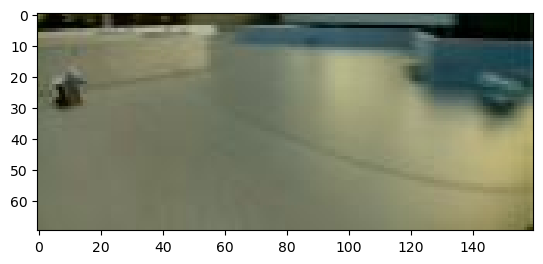

In [28]:
plt.imshow(cv2.imread(images[0])[50:, ...])

In [75]:
def transforms(cv_image_rgb):
    cv_image_rgb = cv_image_rgb[50:, ...] # cropping x
    return apply_normalization(cv_image_rgb)


def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (
        tf.py_function(load_image, [image_path], tf.float32),
        tf.py_function(preprocess_labels, [label], np.float32)
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

2023-01-24 12:32:41.232692: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/Pavlo/miniconda3/envs/donkey/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(64, 70, 160, 3)
(64, 1)


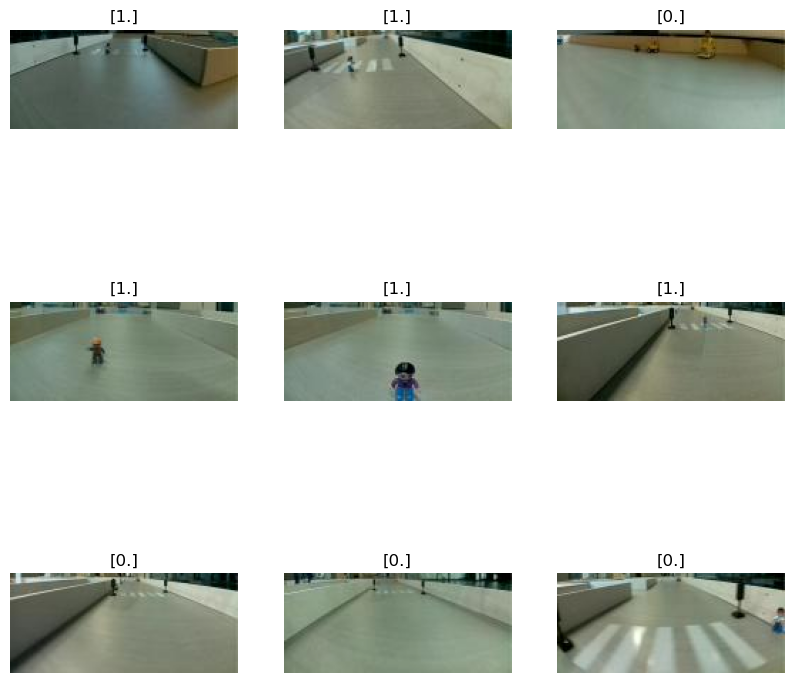

In [76]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    # plt.imshow((image_batch[-i].numpy() * 255).astype(np.uint8))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

# Train the Model

In [78]:
# TODO plotting
# TODO Augmentation
# TODO add confusion matrix and choose a threshold using ROC

model = tf.keras.Sequential([
    InputLayer(input_shape=(70, 160, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

n_epochs = 10
log_frequency = 50
threshold = 0.5

optimizer = Adam(learning_rate=0.0001)
criterion = BinaryCrossentropy()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(n_epochs):
    step = 0
    # Training
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(image_batch, training=True)
            loss_value = criterion(label_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy
        running_loss += current_loss
        running_accuracy += current_accuracy

        if (step + 1) % log_frequency == 0:
            print(
                f'Train [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    train_loss_history.append(total_loss / step)
    train_accuracy_history.append(total_accuracy / step)

    # Validation
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_val):
        logits = model(image_batch, training=False)
        loss_value = criterion(label_batch, logits)

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Val [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    val_loss_history.append(total_loss / step)
    val_accuracy_history.append(total_accuracy / step)

Train [1/10, 50/?]: Loss 0.6970440590381622, Accuracy 0.5625
Train [1/10, 100/?]: Loss 0.6494066977500915, Accuracy 0.629375
Train [1/10, 150/?]: Loss 0.6365662086009979, Accuracy 0.6321875
Train [1/10, 200/?]: Loss 0.6109014689922333, Accuracy 0.66
Train [1/10, 250/?]: Loss 0.5842265284061432, Accuracy 0.6903125
Train [1/10, 300/?]: Loss 0.5616100072860718, Accuracy 0.7090625
Train [1/10, 350/?]: Loss 0.5285185623168945, Accuracy 0.734375
Val [1/10, 50/?]: Loss 0.5177230310440063, Accuracy 0.826875
Train [2/10, 50/?]: Loss 0.49167887210845945, Accuracy 0.769375
Train [2/10, 100/?]: Loss 0.4612014716863632, Accuracy 0.7859375
Train [2/10, 150/?]: Loss 0.4320099824666977, Accuracy 0.8075
Train [2/10, 200/?]: Loss 0.4146623635292053, Accuracy 0.8175
Train [2/10, 250/?]: Loss 0.37863218307495117, Accuracy 0.8359375
Train [2/10, 300/?]: Loss 0.3505327618122101, Accuracy 0.85125
Train [2/10, 350/?]: Loss 0.32378195226192474, Accuracy 0.86125
Val [2/10, 50/?]: Loss 0.35118632078170775, Accur

# Evaluate the Model

Text(0.5, 1.0, 'Accuracy')

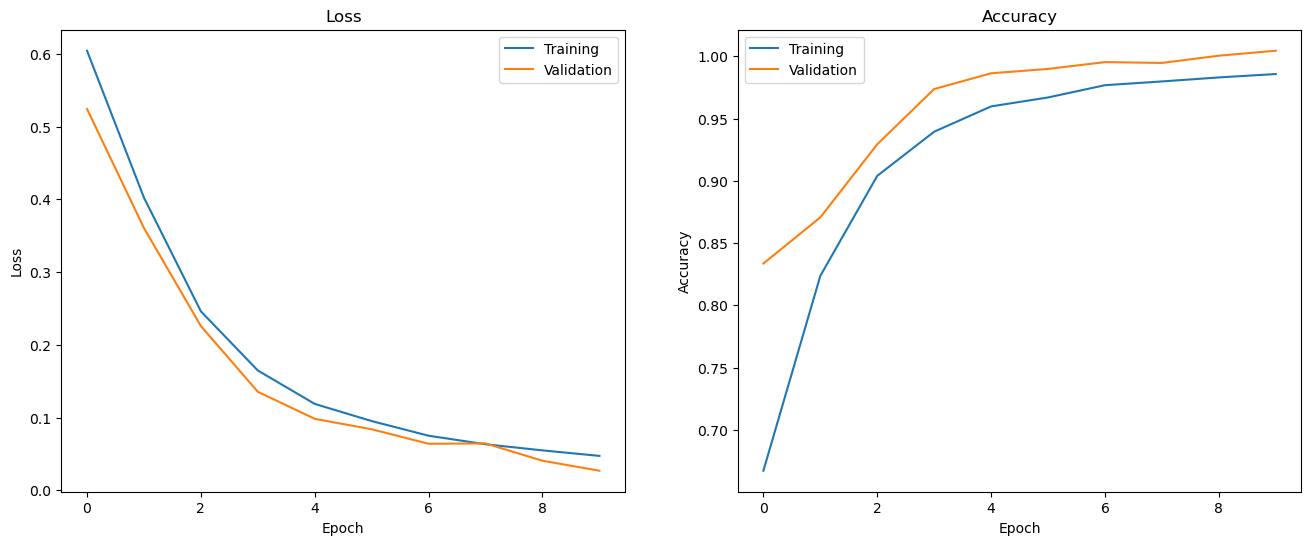

In [79]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [80]:
# Evaluation
threshold = 0.5

test_loss = 0.0
test_accuracy = 0.0
batches = 0
for step, (image_batch, label_batch) in enumerate(ds_test):
    logits = model(image_batch, training=False)
    loss_value = criterion(label_batch, logits)

    # Metrics and Logging
    current_loss = loss_value.numpy()
    current_accuracy = accuracy_score(label_batch, logits > threshold)

    test_loss += current_loss
    test_accuracy += current_accuracy
    batches += 1

test_loss /= batches
test_accuracy /= batches

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.028589496160593798
Test Accuracy: 0.9946933962264151


In [81]:
model.save("../models/pedestrian_detector_v8")

INFO:tensorflow:Assets written to: ../models/pedestrian_detector_v8/assets
